# Hands-on: EDA

This hands-on will cover some techniques for exploratory data analysis using the Citibike Trip Histories dataset. The first few sections include code to prepare the data.

In [45]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data - CitiBike Trip Histories

CitiBike provides the data of the bike share through this website: https://www.citibikenyc.com/system-data

For this exercise, we'll be using their trip history data which may be found [here](https://s3.amazonaws.com/tripdata/index.html). 

Kindly choose a 2021 month file to download (not the ones with JC as the prefix). You can download data for January or Febuary (20-50MB in file size for slow internet connections) and extract it to your data folder.

In [46]:
data = pd.read_csv('data/citibike/202102-citibike-tripdata.csv')
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,683,2021-02-01 00:08:57.2940,2021-02-01 00:20:21.2680,3483,Montgomery St,40.719420,-74.050990,3203,Hamilton Park,40.727596,-74.044247,40517,Subscriber,1958,1
1,2850,2021-02-01 00:21:12.4910,2021-02-01 01:08:42.9560,3203,Hamilton Park,40.727596,-74.044247,3275,Columbus Drive,40.718355,-74.038914,40517,Subscriber,1958,1
2,545,2021-02-01 00:53:08.7500,2021-02-01 01:02:14.3890,3220,5 Corners Library,40.734961,-74.059503,3212,Christ Hospital,40.734786,-74.050444,44907,Customer,1996,1
3,473,2021-02-01 00:59:10.1110,2021-02-01 01:07:03.8480,3220,5 Corners Library,40.734961,-74.059503,3210,Pershing Field,40.742677,-74.051789,29727,Subscriber,1987,2
4,748,2021-02-01 01:01:29.4990,2021-02-01 01:13:57.8940,3210,Pershing Field,40.742677,-74.051789,3269,Brunswick & 6th,40.726012,-74.050389,45550,Subscriber,1962,1


## Feature Extraction

In [47]:
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])

data['dayofweek'] = data['starttime'].dt.dayofweek
data['hourofday'] = data['starttime'].dt.hour
data['year'] = data['starttime'].dt.year

## Feature Transformation

In [48]:
data['duration_min'] = data['tripduration']/60

## Feature Generation

In [49]:
data['age'] = data['starttime'].dt.year - data['birth year']
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dayofweek,hourofday,year,duration_min,age
0,683,2021-02-01 00:08:57.294,2021-02-01 00:20:21.268,3483,Montgomery St,40.719420,-74.050990,3203,Hamilton Park,40.727596,-74.044247,40517,Subscriber,1958,1,0,0,2021,11.383333,63
1,2850,2021-02-01 00:21:12.491,2021-02-01 01:08:42.956,3203,Hamilton Park,40.727596,-74.044247,3275,Columbus Drive,40.718355,-74.038914,40517,Subscriber,1958,1,0,0,2021,47.500000,63
2,545,2021-02-01 00:53:08.750,2021-02-01 01:02:14.389,3220,5 Corners Library,40.734961,-74.059503,3212,Christ Hospital,40.734786,-74.050444,44907,Customer,1996,1,0,0,2021,9.083333,25
3,473,2021-02-01 00:59:10.111,2021-02-01 01:07:03.848,3220,5 Corners Library,40.734961,-74.059503,3210,Pershing Field,40.742677,-74.051789,29727,Subscriber,1987,2,0,0,2021,7.883333,34
4,748,2021-02-01 01:01:29.499,2021-02-01 01:13:57.894,3210,Pershing Field,40.742677,-74.051789,3269,Brunswick & 6th,40.726012,-74.050389,45550,Subscriber,1962,1,0,1,2021,12.466667,59


#### Distance

Another feature we can generate from the data is distance. Although the provided values are in longitude and latitudes and they're measured in degrees, the distance calculated from these points would also be in degrees (and not meters). 

There's actually a library that specifically handles geospatial data called `geopy` ([Link](https://geopy.readthedocs.io/en/stable/#module-geopy.distance)). For simplicity sake in this tutorial, we use an existing function that calculates the geodesic distance using the Haversine formula given the starting and ending longitude and latitudes: `calculate_distance(lat1, lon1, lat2, lon2)`

Credits to [Wayne Dyck](https://gist.github.com/rochacbruno/2883505) for the function.

In [50]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the distance provided a pair of longitudes and latitudes
    using the Haversine formula
    
    Returns the distance in kilometers.
    """
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [51]:
data['distance_km'] = data.apply(lambda x: calculate_distance(x['start station latitude'], x['start station longitude'],
                                        x['end station latitude'], x['end station longitude']), axis=1)

----
----

# Exploratory Data Analysis

We will do the following:
1. Examine the size and structure of the data
2. Examine each field individually
3. Examine relationships/correlations
4. Identify anomalies/outliers

## 1. Size and structure of the data

In [52]:
data.shape

(4725, 21)

After feater transformations, the dataset now has 634,631 observations with 21 variables.

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4725 entries, 0 to 4724
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   tripduration             4725 non-null   int64         
 1   starttime                4725 non-null   datetime64[ns]
 2   stoptime                 4725 non-null   datetime64[ns]
 3   start station id         4725 non-null   int64         
 4   start station name       4725 non-null   object        
 5   start station latitude   4725 non-null   float64       
 6   start station longitude  4725 non-null   float64       
 7   end station id           4725 non-null   int64         
 8   end station name         4725 non-null   object        
 9   end station latitude     4725 non-null   float64       
 10  end station longitude    4725 non-null   float64       
 11  bikeid                   4725 non-null   int64         
 12  usertype                 4725 non-

The dataset has a variety of datatypes: integer and float values, date and time, and strings. There are no variables with null/missing values.

In [54]:
# Get descriptive statistics of quantitative variables
data.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,dayofweek,hourofday,year,duration_min,age,distance_km
count,4.725000e+03,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000,4725.0,4725.000000,4725.000000,4725.000000
mean,1.670438e+03,3304.241481,40.722727,-74.047113,3302.378624,40.722550,-74.046446,41115.517037,1972.799365,0.289735,3.268995,15.208889,2021.0,27.840631,48.200635,1.028391
std,2.041336e+04,181.453889,0.006908,0.011888,197.710038,0.006754,0.011639,5683.095080,7.463825,0.547945,1.889804,7.223199,0.0,340.222716,7.463825,0.731979
min,6.100000e+01,3184.000000,40.711130,-74.083639,151.000000,40.703554,-74.083639,24987.000000,1949.000000,0.000000,0.000000,0.000000,2021.0,1.016667,20.000000,0.000000
25%,3.250000e+02,3195.000000,40.717733,-74.051789,3195.000000,40.717733,-74.050656,39661.000000,1970.000000,0.000000,2.000000,12.000000,2021.0,5.416667,51.000000,0.570314
50%,5.290000e+02,3210.000000,40.721630,-74.044247,3209.000000,40.721525,-74.043845,42495.000000,1970.000000,0.000000,3.000000,18.000000,2021.0,8.816667,51.000000,0.889020
75%,9.500000e+02,3276.000000,40.727551,-74.038051,3276.000000,40.727224,-74.037683,44744.000000,1970.000000,0.000000,5.000000,21.000000,2021.0,15.833333,51.000000,1.430533
max,1.086982e+06,3792.000000,40.748716,-74.032108,3794.000000,40.751873,-73.977706,49503.000000,2001.000000,2.000000,6.000000,23.000000,2021.0,18116.366667,72.000000,8.349835


Although these variables are all quantitative, it doesn't really make sense to look at the statistics for unique IDs and spatial data like `start station id`, `start station latitude`, `start station longitude`, and `bikeid`, among others. Here, we will just focus on the values for `birth year`, `duration_min`, `age`, and `distance_km`.

Few insights from the `data.describe()` function:

1. The minimum `birth year` is 1885 which has a remarkably large difference from the 25th percentile value. Can this be anomalous data?
2. There is a very large difference between the maximum and 75th percentile values of `duration_min` and `age`.
3. Observations #1 & #2 indicate possible outliers in the data. 

In [55]:
data.describe(include=np.object)

,start station name,end station name,usertype
count,4725,4725,4725
unique,51,55,2
top,Newport Pkwy,Grove St PATH,Customer
freq,287,298,3624


These are the descriptive stats for the categorical variables. 

## 2. Examining individual variables

Now, we can start generating simple visualizations to help us better understand the values in each variable.

### User type

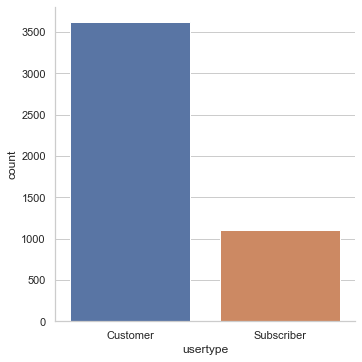

In [56]:
sns.set_theme(style="whitegrid")

usertype_plot = sns.catplot(x="usertype", kind="count", order=["Customer", "Subscriber"], data=data)

There are more one-time users of CitiBike than there are subscribers.

### Age

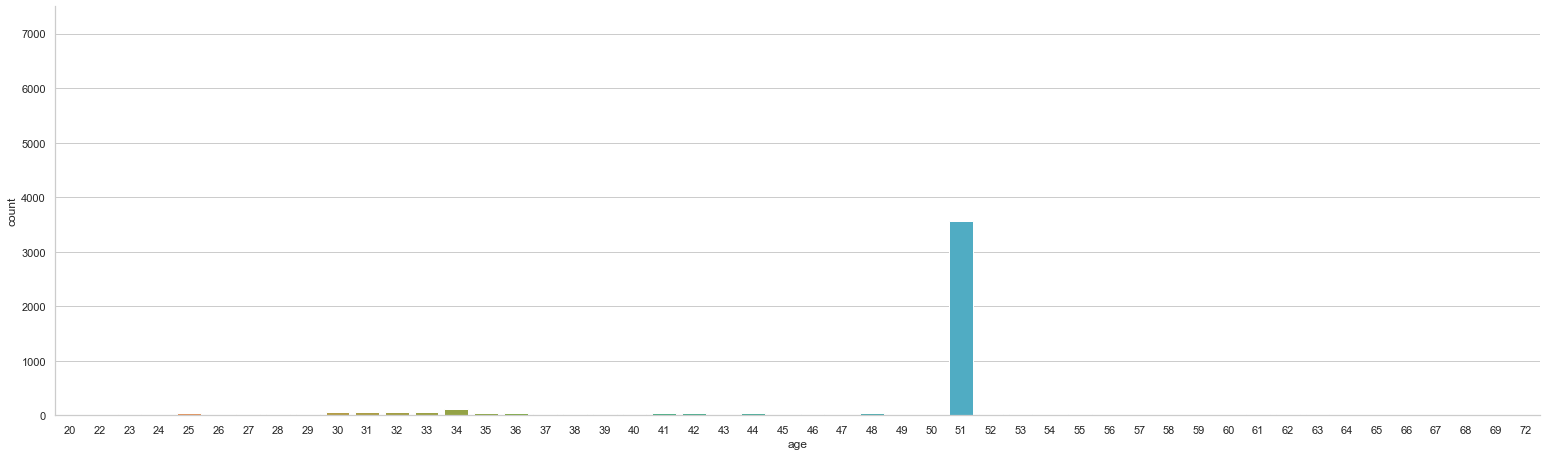

In [57]:
age_plot = sns.catplot(x="age", kind="count", data=data)
age_plot.set(ylim=(0,7500)) # Limit the maximum y-axis value because of one outlier count for age 52
age_plot.fig.set_size_inches(25, 6.5)

In [58]:
data["age"].value_counts()

51    3563
34     120
31      65
30      65
33      55
32      52
44      50
36      49
35      47
25      43
42      40
41      38
48      36
29      32
61      30
38      29
37      29
39      28
63      28
28      25
23      23
52      22
53      20
55      20
27      19
62      19
40      18
46      17
26      13
43      13
59      12
50      11
65      10
54      10
49       9
57       9
72       8
45       8
24       6
64       5
56       5
60       4
69       4
68       4
47       3
58       3
67       2
22       2
66       1
20       1
Name: age, dtype: int64

### Starting Stations

In [59]:
start_stations = data["start station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
start_stations = start_stations.nlargest(10, 'counts')
start_stations

,Station name,counts
0,Newport Pkwy,287
1,Grove St PATH,272
2,Hamilton Park,269
3,Marin Light Rail,225
4,Sip Ave,217
5,Newport PATH,201
6,Warren St,163
7,Harborside,161
8,JC Medical Center,157
9,Columbus Dr at Exchange Pl,154


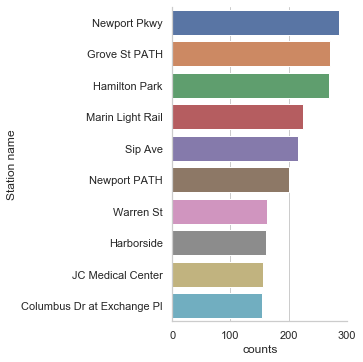

In [60]:
start_station_plot = sns.catplot(y="Station name", x="counts", orient="h", kind="bar", data=start_stations)

### Ending stations

In [61]:
end_stations = data["end station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
end_stations = end_stations.nlargest(10, 'counts')
end_stations

,Station name,counts
0,Grove St PATH,298
1,Newport Pkwy,293
2,Hamilton Park,261
3,Sip Ave,220
4,Newport PATH,218
5,Marin Light Rail,208
6,City Hall,164
7,Warren St,164
8,JC Medical Center,163
9,Harborside,161


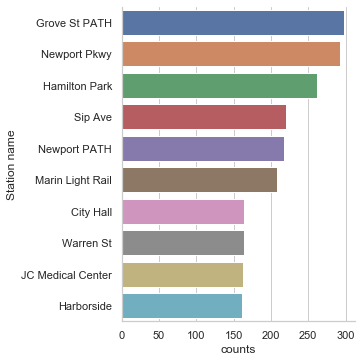

In [62]:
end_station_plot = sns.catplot(y="Station name", x="counts", orient="h", kind="bar", data=end_stations)

We can see from both plots that the top 10 start and end stations are consistent with each other. This indicates high taffic areas which can be potential locations for adding more bikes and bike docks. 

### Origin-Destination Pairs

Here we create `od_trips` which contains the origin-destination pairs derived from the unique pairs of `start station name` and `end station name`.

In [63]:
## Count of rides per OD
od_trips = data.groupby(['start station name', 'end station name'], as_index=False)['bikeid'].count()
od_trips = od_trips.rename(columns={"start station name": "start", "end station name": "end", "bikeid": "total_trips"}, errors="raise")
od_trips.head()

,start,end,total_trips
0,5 Corners Library,5 Corners Library,3
1,5 Corners Library,Brunswick St,1
2,5 Corners Library,Christ Hospital,3
3,5 Corners Library,City Hall,1
4,5 Corners Library,Columbus Drive,1


In [64]:
od_trips["od"] = od_trips["start"] + " to " + od_trips["end"]
od_trips

,start,end,total_trips,od
0,5 Corners Library,5 Corners Library,3,5 Corners Library to 5 Corners Library
1,5 Corners Library,Brunswick St,1,5 Corners Library to Brunswick St
2,5 Corners Library,Christ Hospital,3,5 Corners Library to Christ Hospital
3,5 Corners Library,City Hall,1,5 Corners Library to City Hall
4,5 Corners Library,Columbus Drive,1,5 Corners Library to Columbus Drive
...,...,...,...,...
1149,York St,Newport Pkwy,1,York St to Newport Pkwy
1150,York St,Paulus Hook,1,York St to Paulus Hook
1151,York St,Van Vorst Park,1,York St to Van Vorst Park
1152,York St,Warren St,1,York St to Warren St


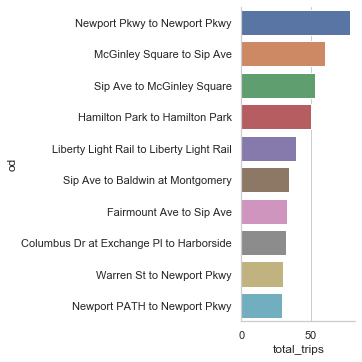

In [65]:
od_rank_plot = sns.catplot(y="od", x="total_trips", orient="h", kind="bar", data=od_trips.nlargest(10, "total_trips"))

### Origin-Destination Matrix

In this part, we focus on analyzing the number of trips between the top 10 `start` and `end` stations. It would be impossible to visually analyze for all possible pairs because the dataset is too big.

In [66]:
# Get the trips between the top 10 stations.

od_topten = od_trips[od_trips.start.isin(start_stations["Station name"]) & od_trips.end.isin(end_stations["Station name"])]
od_topten

,start,end,total_trips,od
179,Columbus Dr at Exchange Pl,City Hall,2,Columbus Dr at Exchange Pl to City Hall
185,Columbus Dr at Exchange Pl,Grove St PATH,4,Columbus Dr at Exchange Pl to Grove St PATH
186,Columbus Dr at Exchange Pl,Hamilton Park,5,Columbus Dr at Exchange Pl to Hamilton Park
187,Columbus Dr at Exchange Pl,Harborside,32,Columbus Dr at Exchange Pl to Harborside
192,Columbus Dr at Exchange Pl,Marin Light Rail,9,Columbus Dr at Exchange Pl to Marin Light Rail
...,...,...,...,...
1087,Warren St,JC Medical Center,8,Warren St to JC Medical Center
1092,Warren St,Marin Light Rail,8,Warren St to Marin Light Rail
1098,Warren St,Newport PATH,12,Warren St to Newport PATH
1099,Warren St,Newport Pkwy,30,Warren St to Newport Pkwy


In [67]:
# Create a matrix

od_matrix = pd.pivot_table(od_topten, index='start', columns='end', values='total_trips', aggfunc=np.sum, fill_value=0)
od_matrix

end,City Hall,Grove St PATH,Hamilton Park,Harborside,JC Medical Center,Marin Light Rail,Newport PATH,Newport Pkwy,Sip Ave,Warren St
start,,,,,,,,,,
Columbus Dr at Exchange Pl,2,4,5,32,0,9,13,14,1,5
Grove St PATH,9,14,15,5,10,24,3,3,2,5
Hamilton Park,6,26,50,3,6,4,18,9,0,10
Harborside,1,8,4,21,2,3,22,11,1,2
JC Medical Center,13,10,9,1,24,15,12,3,0,9
Marin Light Rail,14,27,5,9,11,25,18,3,0,15
Newport PATH,5,3,18,22,6,12,12,29,1,7
Newport Pkwy,4,4,8,11,5,6,12,78,0,25
Sip Ave,1,0,0,1,0,0,3,2,16,1


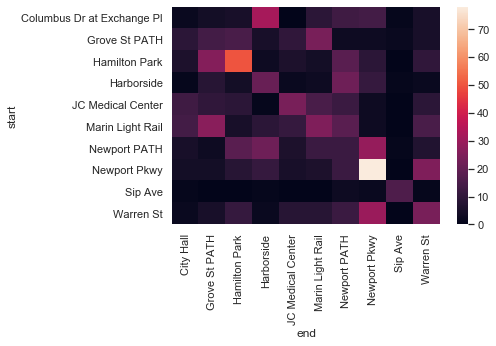

In [68]:
# Generate a heatmap

od_heatmap = sns.heatmap(od_matrix)

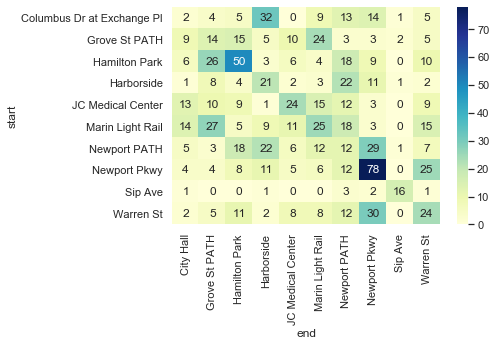

In [69]:
# Change color palette

od_heatmap = sns.heatmap(od_matrix, cmap="YlGnBu", annot=True, fmt="d")

### Gender

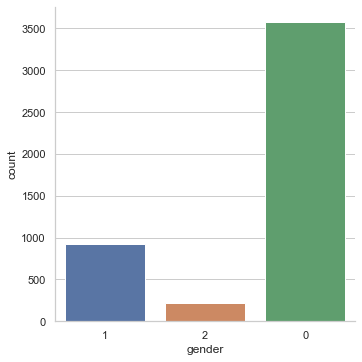

In [70]:
gender_plot = sns.catplot(x="gender", kind="count", order=[1, 2, 0], data=data)

It seems that the dataset contains mostly zero (0) values for the gender. We can continue our analysis by removing those trips with unknown gender.

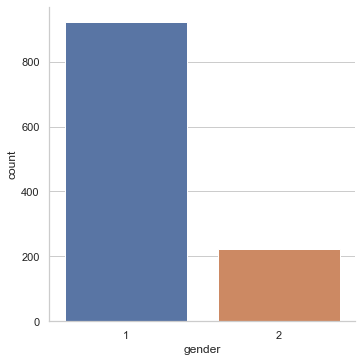

In [71]:
gender_plot = sns.catplot(x="gender", kind="count", order=[1, 2], data=data[data["gender"] > 0])

### Day of week

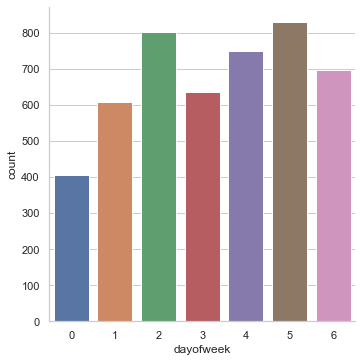

In [72]:
dow_plot = sns.catplot(x="dayofweek", kind="count", data=data)

The values for `dayofweek` starts with `0` or `Monday` and ends with `6` or `Sunday`. Based on the bar plot above, most trips happen on Wednesdays, Fridays and Saturdays.

### Hour of day

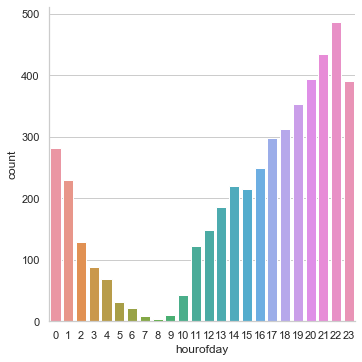

In [73]:
hod_plot = sns.catplot(x="hourofday", kind="count", data=data)

From the plot, the number of trips starts increasing from 12 noon and peaks at 5PM. 

### Duration in minutes

In [74]:
data["duration_min"].describe()

count     4725.000000
mean        27.840631
std        340.222716
min          1.016667
25%          5.416667
50%          8.816667
75%         15.833333
max      18116.366667
Name: duration_min, dtype: float64

### Detect and remove outliers

Outliers are defined as values that is more than 3 standard deviations away from the mean. Here, we detect them by computing the z score of each value, which is relative to the mean and standard deviation.

In [75]:
z_scores = zscore(data["duration_min"]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_entries = (abs_z_scores < 3) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
duration_min_outliers = (abs_z_scores >= 3)
data[duration_min_outliers].duration_min # Show outlier values

20      18116.366667
392      4165.066667
647      5839.800000
1279     2380.333333
1567     1065.983333
1820     2310.266667
2481     2247.066667
2841     2233.266667
2943     1078.350000
3092     8577.983333
3821     5498.733333
3924     2154.800000
3969     5904.233333
Name: duration_min, dtype: float64

#### Histograms with KDE

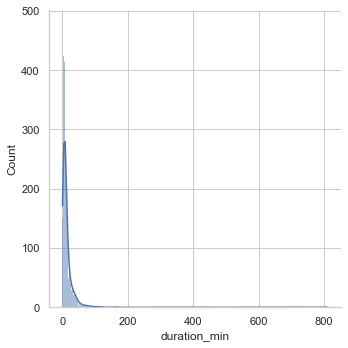

In [76]:
duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)

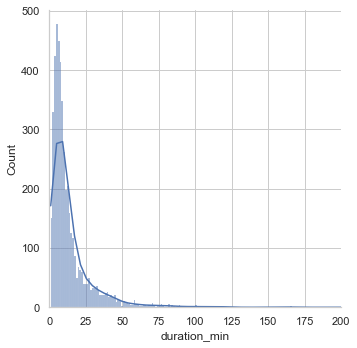

In [77]:
# Zoom in a little closer. Let's limit the x-axis to only show values up to 200

duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)
duration_plot.set(xlim=(0, 200))

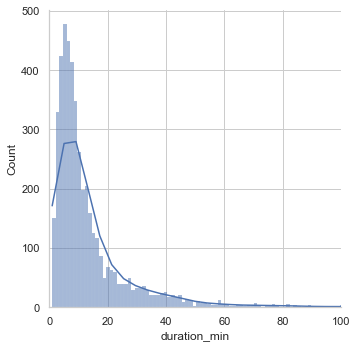

In [78]:
# Zoom in more. Let's limit the x-axis to only show values up to 100

duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)
duration_plot.set(xlim=(0, 100))

#### ECDF with Rug Plots

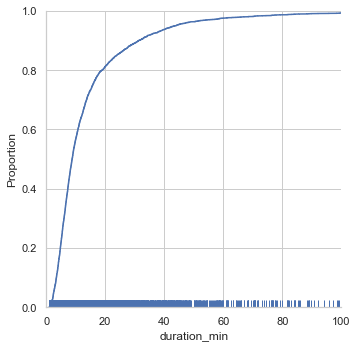

In [79]:
duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kind="ecdf", rug=True)
duration_plot.set(xlim=(0, 100))

## 3. Examine relationships/correlations

### User type and gender

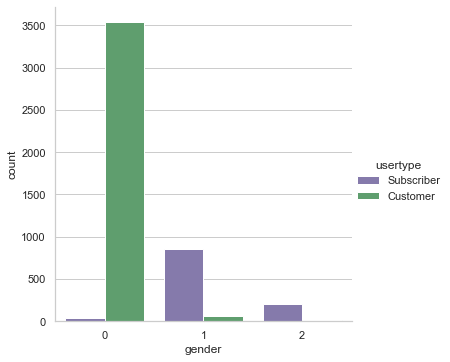

In [80]:
usertype_gender_plot = sns.catplot(x="gender", 
                                   kind="count", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   data=data)

- Users with 24-hour pass or 3-day passes did not have their gender information recorded.
- More male subscribers than females. 

### Trip distance, duration and user type

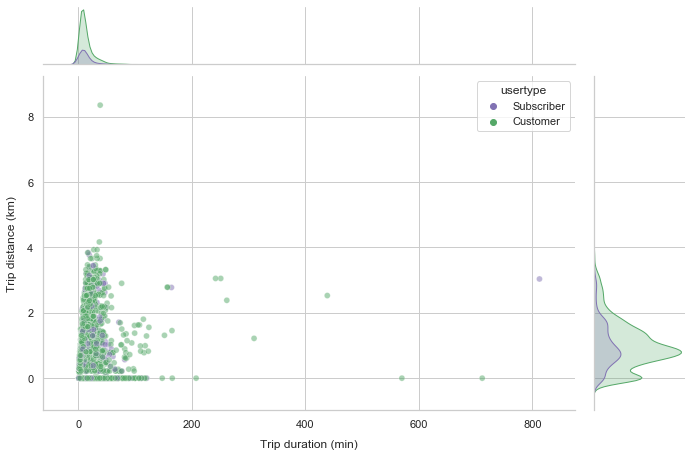

In [81]:
dur_dist_user_plot = sns.jointplot(data=data[filtered_entries], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)

In [82]:
z_scores = zscore(data["distance_km"]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_dist = (abs_z_scores < 3) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
dist_outliers = (abs_z_scores >= 3)
data[dist_outliers].distance_km # Show outlier values

87      3.281467
142     8.349835
196     3.281888
507     3.387563
1004    3.769794
1363    3.285017
1454    3.285017
1605    3.435339
1618    3.285143
1631    3.660745
1642    3.660745
1783    3.660745
1808    3.660745
2112    3.285017
2305    3.743791
2339    3.285017
2562    3.246917
2860    3.285017
2979    3.285017
3257    3.836830
3289    3.464111
3418    3.317784
3420    3.317784
3649    3.354213
3653    3.418478
3680    3.928430
3932    3.836830
3966    3.463201
4008    3.928430
4095    3.443084
4204    3.318394
4431    4.165345
Name: distance_km, dtype: float64

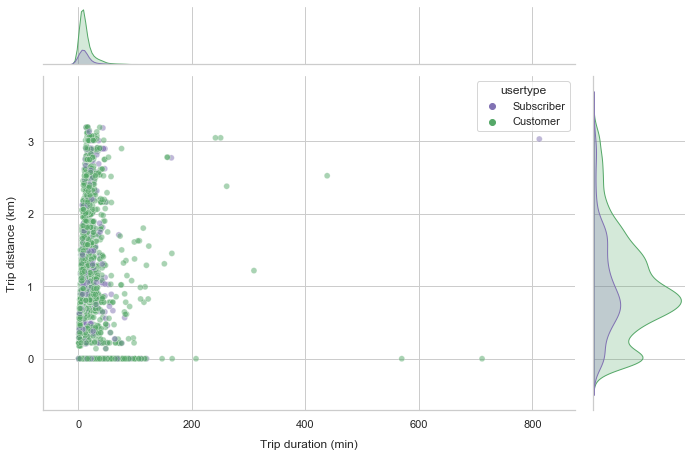

In [83]:
# Plot with outliers for both duration and distance
dur_dist_user_plot = sns.jointplot(data=data[filtered_entries & filtered_dist], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)

### Get correlation between quantitative variables

In [84]:
data_to_corr = data[["gender", "duration_min", "age", "distance_km"]]
data_to_corr

,gender,duration_min,age,distance_km
0,1,11.383333,63,1.072089
1,1,47.500000,63,1.121508
2,1,9.083333,25,0.763566
3,2,7.883333,34,1.076380
4,1,12.466667,59,1.856858
...,...,...,...,...
4720,1,5.916667,34,0.692491
4721,0,4.483333,51,0.692491
4722,0,3.216667,51,0.692491
4723,1,42.500000,63,1.307529


In [85]:
z_scores = zscore(data_to_corr[["duration_min", "age", "distance_km"]]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_rows = (abs_z_scores < 3).all(axis=1) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
data_to_corr_outliers = (abs_z_scores >= 3)
data_to_corr[data_to_corr_outliers] # Show outlier values

,gender,duration_min,age,distance_km
2,1,9.083333,25,0.763566
20,2,18116.366667,35,0.941277
31,1,14.366667,25,1.030527
53,1,13.033333,25,1.166187
64,1,16.100000,25,1.379661
...,...,...,...,...
4588,1,7.183333,25,1.114957
4608,2,10.766667,72,1.762006
4650,1,7.666667,25,1.030848
4682,1,9.350000,25,1.030848


In [86]:
data_to_corr = data_to_corr[filtered_rows]

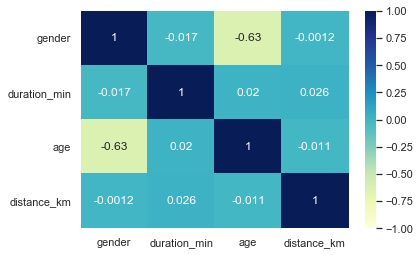

In [87]:
data_corr_heatmap = sns.heatmap(data_to_corr.corr(), 
                                center=0, 
                                cmap="YlGnBu", 
                                annot=True, 
                                vmin=-1, 
                                vmax=1)

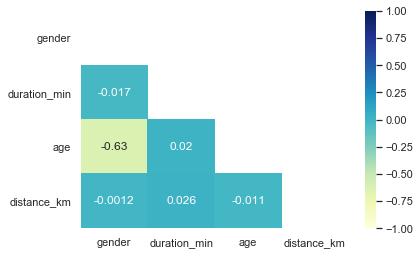

In [88]:
mask = np.triu(np.ones_like(data_to_corr.corr(), dtype=bool))

data_corr_heatmap = sns.heatmap(data_to_corr.corr(), 
                                center=0, 
                                cmap="YlGnBu", 
                                annot=True, 
                                mask=mask,
                                vmin=-1, 
                                vmax=1)

Variables `distance_km` and `duration_min` showed some positive correlation. We can still include them as features in a modeling task later.

### Bivariate: Start station & user type

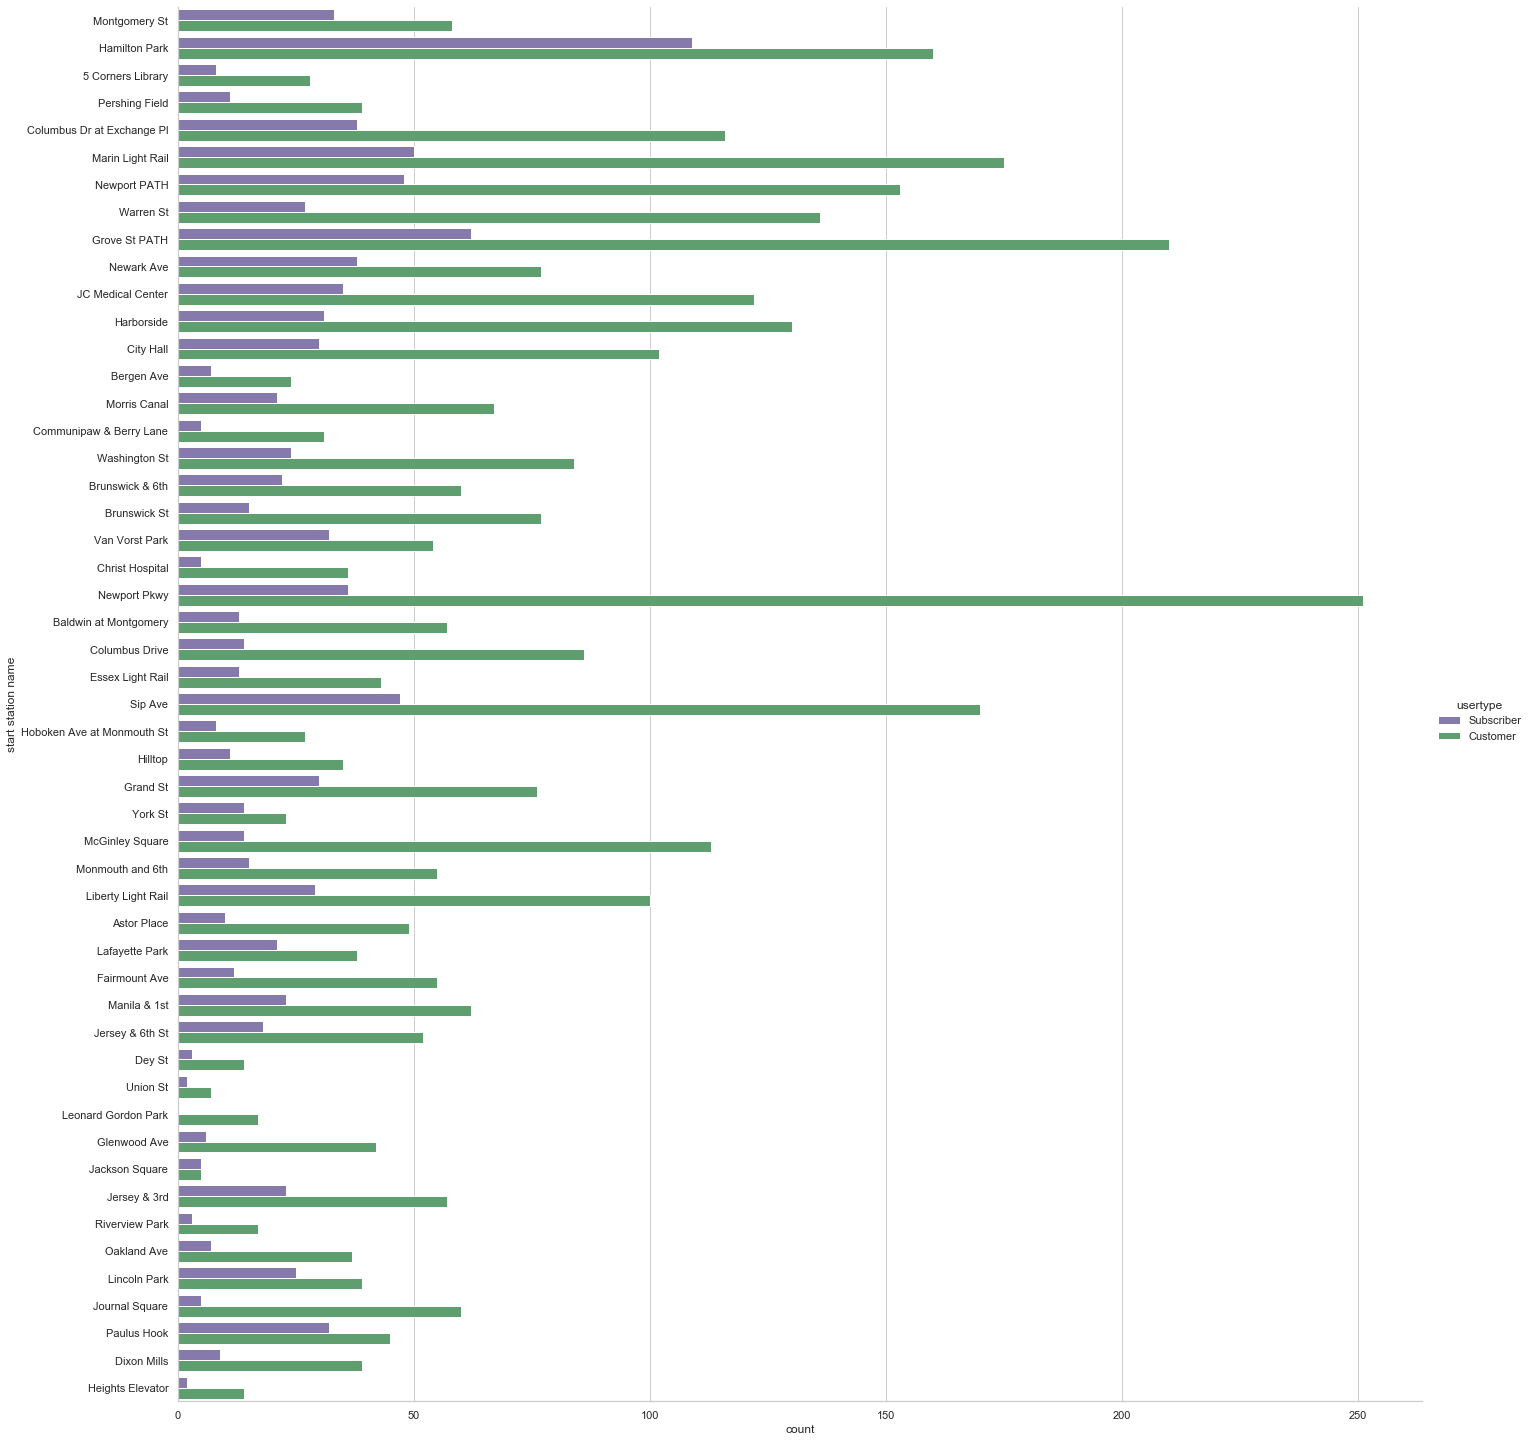

In [197]:
usertype_start_plot = sns.catplot(y="start station name", 
                                   kind="count", 
                                   hue="usertype", 
                                   orient="h",
                                   height = 20,
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   data=data)

In appears that in every station there are always more customers than there are subscribers.

In [134]:
start_userType = data.groupby(['start station name','usertype'], as_index=False)['bikeid'].count()
start_userType = start_userType.rename(columns={"start station name": "start", "usertype": "user", "bikeid": "total_trips"}, errors="raise")
start_userType.head()

,start,user,total_trips
0,5 Corners Library,Customer,28
1,5 Corners Library,Subscriber,8
2,Astor Place,Customer,49
3,Astor Place,Subscriber,10
4,Baldwin at Montgomery,Customer,57


In [144]:
start_userType_cust = start_userType[start_userType["user"] == 'Customer']
start_userType_cust.head()

,start,user,total_trips
0,5 Corners Library,Customer,28
2,Astor Place,Customer,49
4,Baldwin at Montgomery,Customer,57
6,Bergen Ave,Customer,24
8,Brunswick & 6th,Customer,60


A new dataframe is created that contains only the customer user type.

In [210]:
start_userType_sub = start_userType[start_userType["user"] == 'Subscriber']
start_userType_sub.head()

,start,user,total_trips
1,5 Corners Library,Subscriber,8
3,Astor Place,Subscriber,10
5,Baldwin at Montgomery,Subscriber,13
7,Bergen Ave,Subscriber,7
9,Brunswick & 6th,Subscriber,22


Likewise but this time only for subscribers.

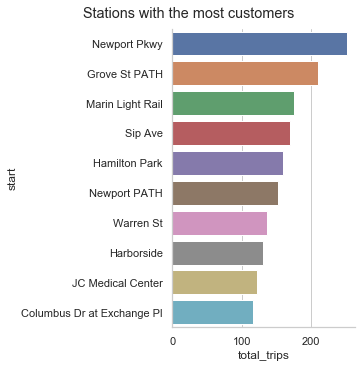

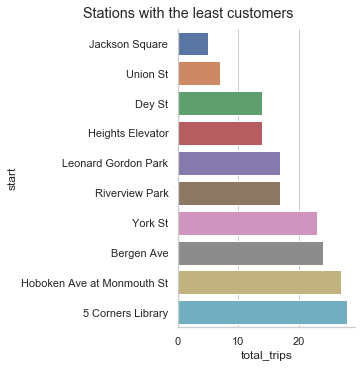

In [173]:
start_userType_cust_highrank_plot = sns.catplot(y="start", x="total_trips", orient="h", kind="bar", data=start_userType_cust.nlargest(10, "total_trips"))
start_userType_cust_lowrank_plot = sns.catplot(y="start", x="total_trips", orient="h", kind="bar", data=start_userType_cust.nsmallest(10, "total_trips"))
start_userType_cust_highrank_plot.fig.subplots_adjust(top=0.92)
start_userType_cust_highrank_plot.fig.suptitle("Starting Stations with the most customers")
start_userType_cust_lowrank_plot.fig.subplots_adjust(top=0.92)
start_userType_cust_lowrank_plot.fig.suptitle("Starting Stations with the least customers")
start_userType_cust_highrank_plot
start_userType_cust_lowrank_plot

Newport Pwky and Grove St PATH holds the top 2 spots for most customers and on the other end, Jackson Square and Union St. holds the bottom 2.

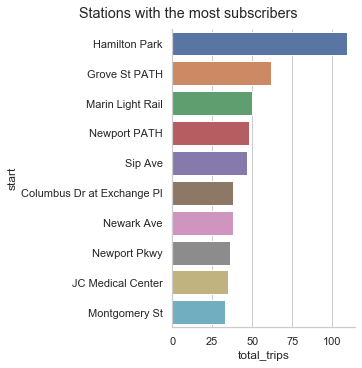

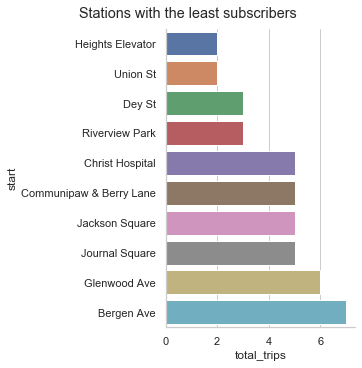

In [175]:
start_userType_sub_highrank_plot = sns.catplot(y="start", x="total_trips", orient="h", kind="bar", data=start_userType_sub.nlargest(10, "total_trips"))
start_userType_sub_lowrank_plot = sns.catplot(y="start", x="total_trips", orient="h", kind="bar", data=start_userType_sub.nsmallest(10, "total_trips"))
start_userType_sub_highrank_plot.fig.subplots_adjust(top=0.92)
start_userType_sub_highrank_plot.fig.suptitle("Starting Stations with the most subscribers")
start_userType_sub_lowrank_plot.fig.subplots_adjust(top=0.92)
start_userType_sub_lowrank_plot.fig.suptitle("Starting Stations with the least subscribers")
start_userType_sub_highrank_plot
start_userType_sub_lowrank_plot

Hamilton Park is the starting station with the most subscribers with Grove St. and Marin Light Rail being the 2nd and 3rd respectively which is the same with customers types. 

The least subscibers is Heights Elevator but the 2nd and 3rd least Union St. and Dey St. is also shared with the customers.

### Bivariate: End station & user type

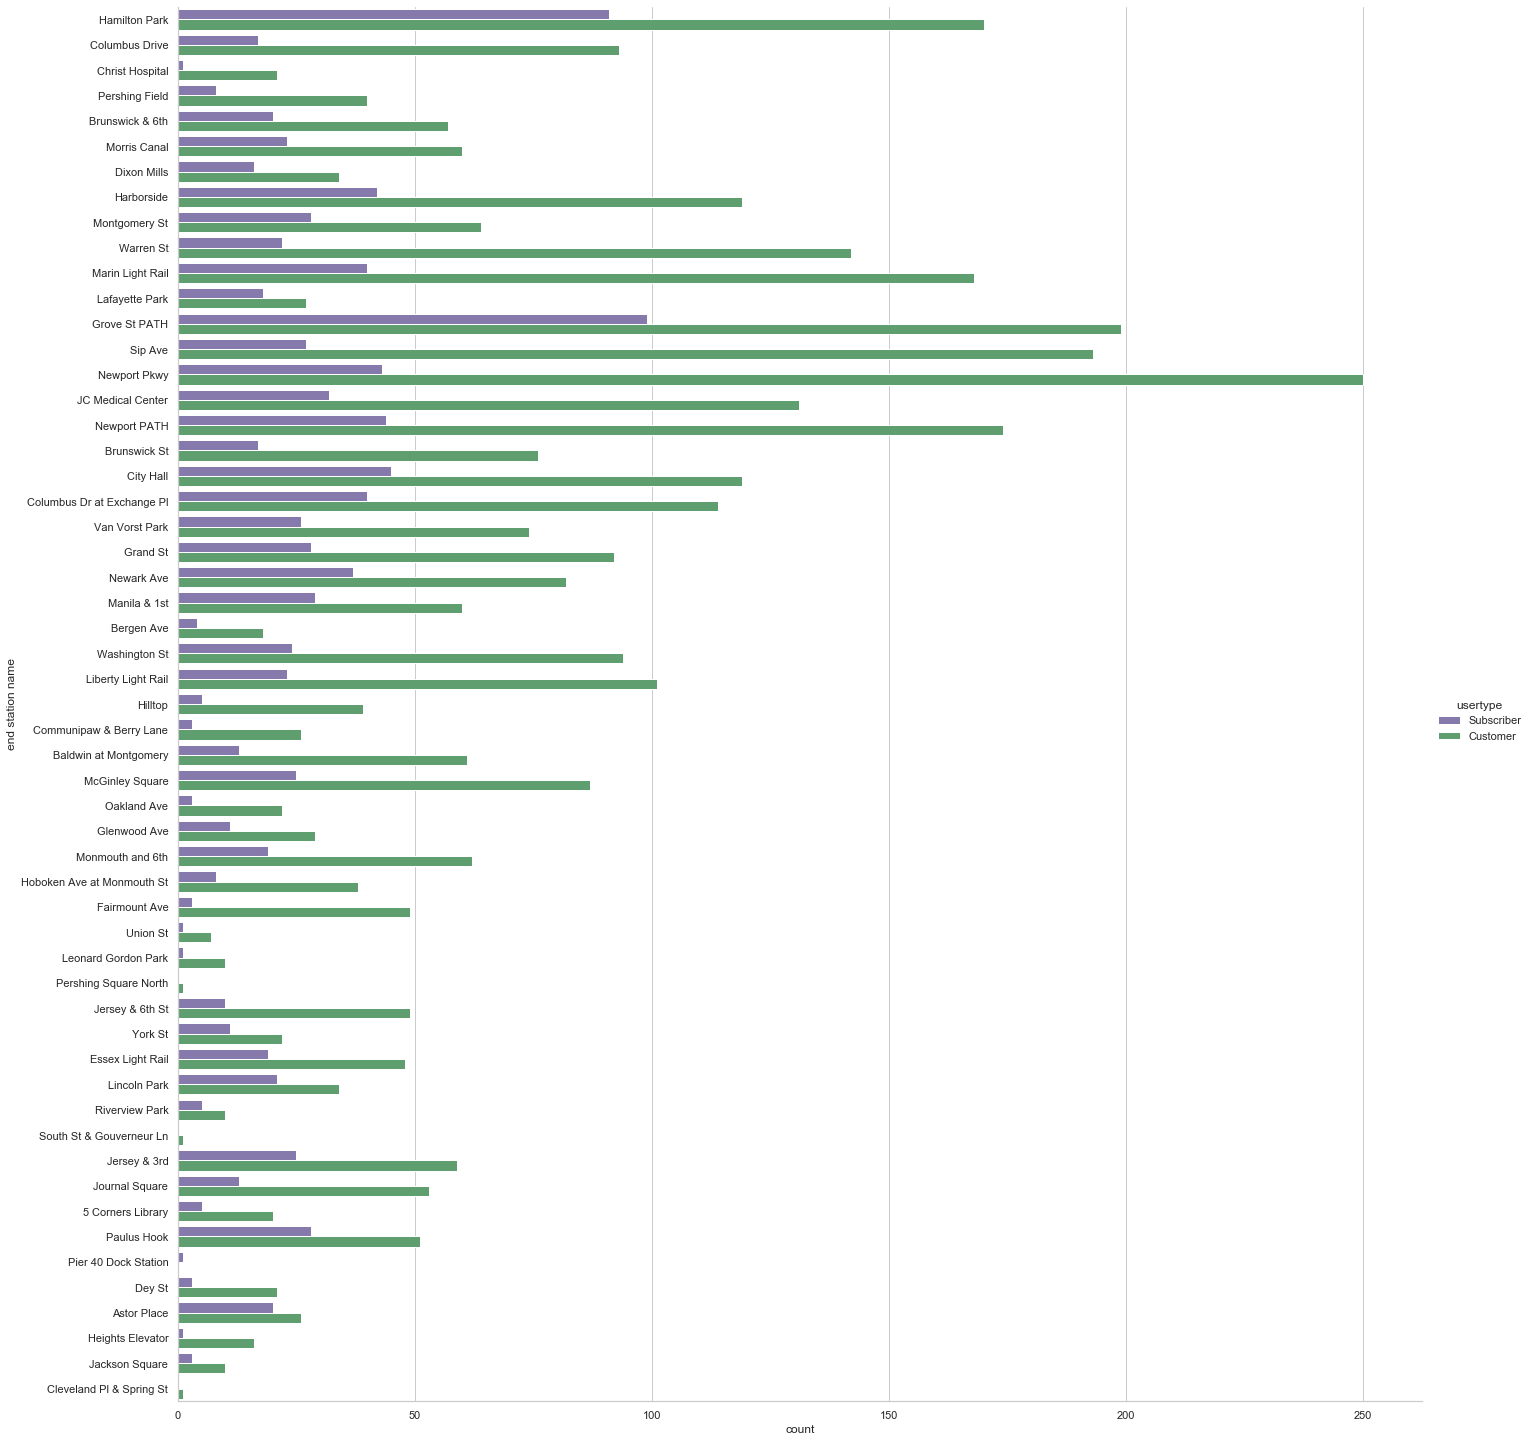

In [196]:
usertype_end_plot = sns.catplot(y="end station name", 
                                   kind="count", 
                                   hue="usertype", 
                                   height = 20,
                                   orient="h",
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   data=data)

Similar to the starting stations, the amount of customers overwhelm the number of subscribers in every end station.

In [179]:
end_userType = data.groupby(['end station name','usertype'], as_index=False)['bikeid'].count()
end_userType = end_userType.rename(columns={"end station name": "end", "usertype": "user", "bikeid": "total_trips"}, errors="raise")
end_userType.head()

,end,user,total_trips
0,5 Corners Library,Customer,20
1,5 Corners Library,Subscriber,5
2,Astor Place,Customer,26
3,Astor Place,Subscriber,20
4,Baldwin at Montgomery,Customer,61


In [219]:
end_userType_cust = end_userType[end_userType["user"] == 'Customer']
end_userType_cust.head()

,end,user,total_trips
0,5 Corners Library,Customer,20
2,Astor Place,Customer,26
4,Baldwin at Montgomery,Customer,61
6,Bergen Ave,Customer,18
8,Brunswick & 6th,Customer,57


Dataframe of customers in end stations.

In [220]:
end_userType_sub = end_userType[end_userType["user"] == 'Subscriber']
end_userType_sub.head()

,end,user,total_trips
1,5 Corners Library,Subscriber,5
3,Astor Place,Subscriber,20
5,Baldwin at Montgomery,Subscriber,13
7,Bergen Ave,Subscriber,4
9,Brunswick & 6th,Subscriber,20


Dataframe of subscribers in end stations.

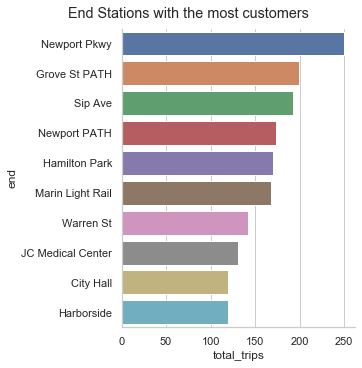

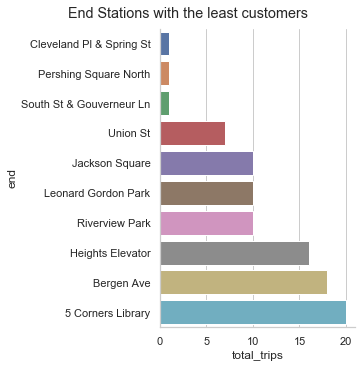

In [223]:
end_userType_cust_highrank_plot = sns.catplot(y="end", x="total_trips", orient="h", kind="bar", data=end_userType_cust.nlargest(10, "total_trips"))
end_userType_cust_lowrank_plot = sns.catplot(y="end", x="total_trips", orient="h", kind="bar", data=end_userType_cust.nsmallest(10, "total_trips"))
end_userType_cust_highrank_plot.fig.subplots_adjust(top=0.92)
end_userType_cust_highrank_plot.fig.suptitle("End Stations with the most customers")
end_userType_cust_lowrank_plot.fig.subplots_adjust(top=0.92)
end_userType_cust_lowrank_plot.fig.suptitle("End Stations with the least customers")
end_userType_cust_highrank_plot
end_userType_cust_lowrank_plot

Newport Pwkey and Grove St. PATH has the most customers which is the same with the starting stations. On the end stations with the least customers we have 3 different stations with similar looking numbers.

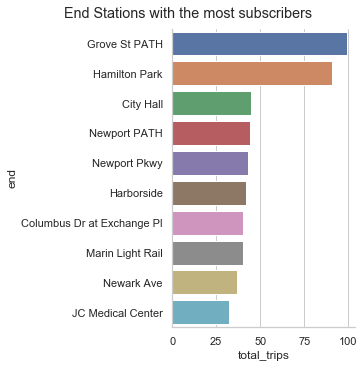

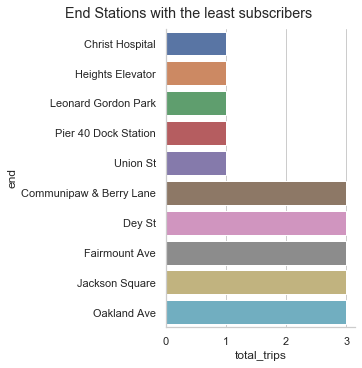

In [213]:
end_userType_sub_highrank_plot = sns.catplot(y="end", x="total_trips", orient="h", kind="bar", data=end_userType_sub.nlargest(10, "total_trips"))
end_userType_sub_lowrank_plot = sns.catplot(y="end", x="total_trips", orient="h", kind="bar", data=end_userType_sub.nsmallest(10, "total_trips"))
end_userType_sub_highrank_plot.fig.subplots_adjust(top=0.92)
end_userType_sub_highrank_plot.fig.suptitle("End Stations with the most subscribers")
end_userType_sub_lowrank_plot.fig.subplots_adjust(top=0.92)
end_userType_sub_lowrank_plot.fig.suptitle("End Stations with the least subscribers")
end_userType_sub_highrank_plot
end_userType_sub_lowrank_plot

Grove St. PATH and Hamilton Park has the most subscibers with similar looking numbers which is similar to the starting stations except this time the former has more subscribers. 

On the end stations with the least subscribers we have 5 different stations with only 1 subsciber only and the other 5 having 3 subscribers only.

### Bivariate: End station & Gender

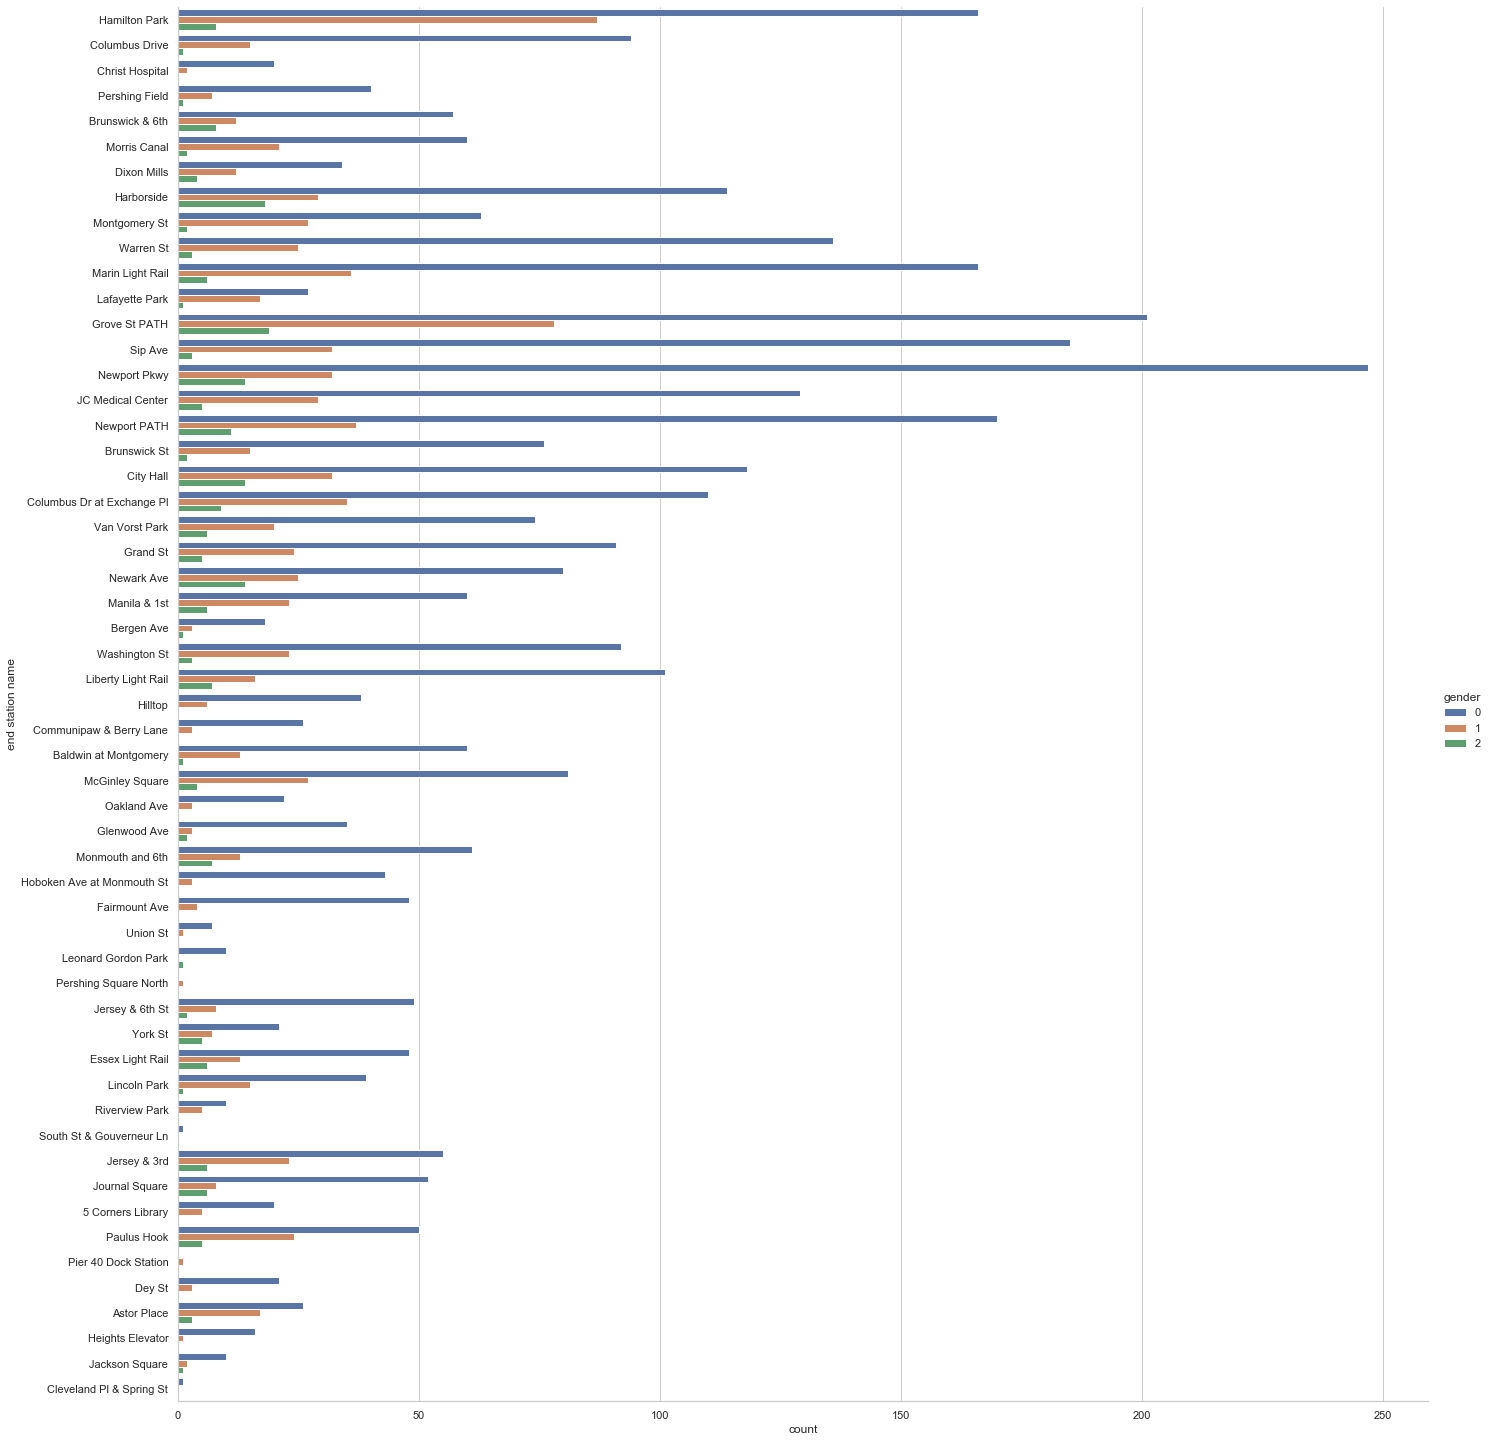

In [198]:
end_gender_plot = sns.catplot(y="end station name", 
                                   kind="count", 
                                   height = 20,
                                   hue="gender", 
                                   orient="h",                                
                                   data=data)

There are an overwhelming amount of users that did not specify their gender in this dataset.

In [200]:
end_gender = data.groupby(['end station name','gender'], as_index=False)['bikeid'].count()
end_gender = end_gender.rename(columns={"end station name": "end", "bikeid": "total_trips"}, errors="raise")
end_gender.head()

,end,gender,total_trips
0,5 Corners Library,0,20
1,5 Corners Library,1,5
2,Astor Place,0,26
3,Astor Place,1,17
4,Astor Place,2,3


In [201]:
end_gender_na = end_gender[end_gender["gender"] == 0]
end_gender_na.head()

,end,gender,total_trips
0,5 Corners Library,0,20
2,Astor Place,0,26
5,Baldwin at Montgomery,0,60
8,Bergen Ave,0,18
11,Brunswick & 6th,0,57


Dataframe of only non specified genders

Dataframe of only non specified genders

In [202]:
end_gender_male = end_gender[end_gender["gender"] == 1]
end_gender_male.head()

,end,gender,total_trips
1,5 Corners Library,1,5
3,Astor Place,1,17
6,Baldwin at Montgomery,1,13
9,Bergen Ave,1,3
12,Brunswick & 6th,1,12


Dataframe of only male users

In [203]:
end_gender_female = end_gender[end_gender["gender"] == 2]
Dataframe of only non specified genders.head()

,end,gender,total_trips
4,Astor Place,2,3
7,Baldwin at Montgomery,2,1
10,Bergen Ave,2,1
13,Brunswick & 6th,2,8
16,Brunswick St,2,2


Dataframe of only female users

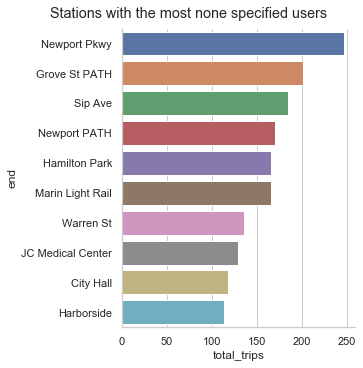

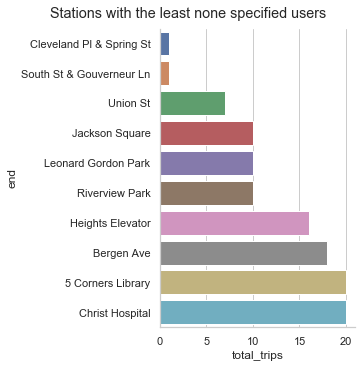

In [204]:
end_gender_na_highrank_plot = sns.catplot(y="end", x="total_trips", orient="h", kind="bar", data=end_gender_na.nlargest(10, "total_trips"))
end_gender_na_lowrank_plot = sns.catplot(y="end", x="total_trips", orient="h", kind="bar", data=end_gender_na.nsmallest(10, "total_trips"))
end_gender_na_highrank_plot.fig.subplots_adjust(top=0.92)
end_gender_na_highrank_plot.fig.suptitle("End Stations with the most none specified users")
end_gender_na_lowrank_plot.fig.subplots_adjust(top=0.92)
end_gender_na_lowrank_plot.fig.suptitle("End Dataframe of only non specified gendersStations with the least none specified users")
end_gender_na_highrank_plot
end_gender_na_lowrank_plot

Most of the gender 0 ends at Newport Pwky and Grove St. Path, which is inline with customers and subscibers of the service. Very few of them take Cleceland PI & Spring St. and South St. & Gouverneur Ln.

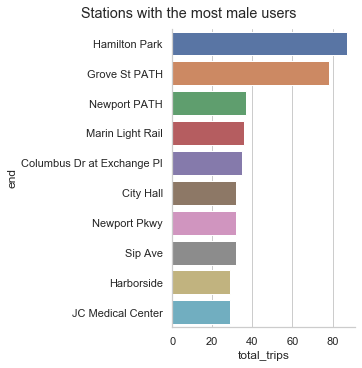

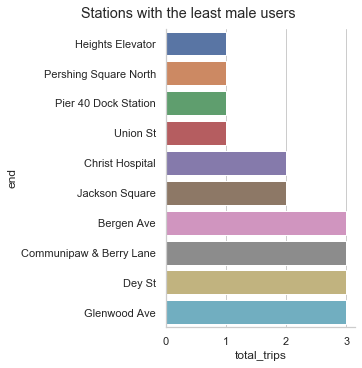

In [205]:
end_gender_male_highrank_plot = sns.catplot(y="end", x="total_trips", orient="h", kind="bar", data=end_gender_male.nlargest(10, "total_trips"))
end_gender_male_lowrank_plot = sns.catplot(y="end", x="total_trips", orient="h", kind="bar", data=end_gender_male.nsmallest(10, "total_trips"))
end_gender_male_highrank_plot.fig.subplots_adjust(top=0.92)
end_gender_male_highrank_plot.fig.suptitle("Stations with the most male users")
end_gender_male_lowrank_plot.fig.subplots_adjust(top=0.92)
end_gender_male_lowrank_plot.fig.suptitle("Stations with the least male users")
end_gender_male_highrank_plot
end_gender_male_lowrank_plot

Most male users end at Hamilton Park and Grove St PATH. While 4 different stations have only one male ending at those.

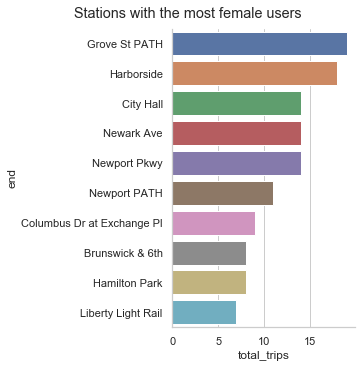

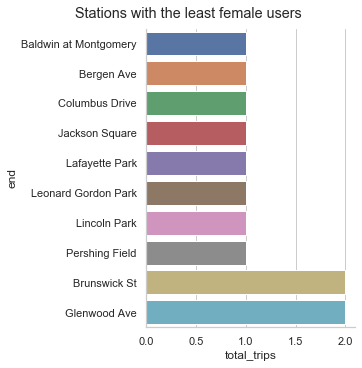

In [206]:
end_gender_female_highrank_plot = sns.catplot(y="end", x="total_trips", orient="h", kind="bar", data=end_gender_female.nlargest(10, "total_trips"))
end_gender_female_lowrank_plot = sns.catplot(y="end", x="total_trips", orient="h", kind="bar", data=end_gender_female.nsmallest(10, "total_trips"))
end_gender_female_highrank_plot.fig.subplots_adjust(top=0.92)
end_gender_female_highrank_plot.fig.suptitle("Stations with the most female users")
end_gender_female_lowrank_plot.fig.subplots_adjust(top=0.92)
end_gender_female_lowrank_plot.fig.suptitle("Stations with the least female users")
end_gender_female_highrank_plot
end_gender_female_lowrank_plot

Most females end in at Grove St. PATH and Harborside, with the former being top 1 for females but top 2 for males. 8 different stations have only 1 female ending at them. 